In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

file_path = "/data/work/shared/safe_data/sleep_skew/skew_project_start_oct_2022/"

'''Getting the sleeping info of the chosen user from another file'''
sleep_sample = pd.read_csv(file_path+"sleep_skew_data_w_demographics.csv")
sleep_sample['sleep_duration_round'] = np.round(sleep_sample['sleep_duration']/3600,2)
sleep_sample['sleep_start'] = pd.to_datetime(sleep_sample['day_label'],unit='d')
sleep_sample['sleep_start_shift'] = np.where(sleep_sample['start_time_num_round'] >= 12,
                                            sleep_sample['sleep_start'],
                                             sleep_sample['sleep_start']-pd.to_timedelta(1,unit='d')
                                            )
sleep_sample['day_of_week'] = sleep_sample['sleep_start_shift'].dt.day_name()
sleep_sample['weekend'] = np.where(sleep_sample['day_of_week'].isin(['Friday','Saturday']),1,0)

sleep_sample['start_time_num_round_25'] = ((sleep_sample['start_time_num_round']%1)*100/60)+sleep_sample['start_time_num_round'].astype(int)
sleep_sample['end_time_num_round_25'] = ((sleep_sample['end_time_num_round']%1)*100/60)+sleep_sample['end_time_num_round'].astype(int)

'''EXCEPTION HANDLING FOR 24.00 : SHOULD SHOW AS 00.00'''

sleep_sample['start_time_num_round_25'] = round(sleep_sample['start_time_num_round_25']*4)/4
sleep_sample['end_time_num_round_25'] = round(sleep_sample['end_time_num_round_25']*4)/4

sleep_sample['start_time_num_round_25'] = np.where(sleep_sample['start_time_num_round_25']==24,0,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(sleep_sample['end_time_num_round_25']==24,0,sleep_sample['end_time_num_round_25'])

''' EXCEPTION HANDLING FOR SLEEP ONSET BETWEEN 23.45 AND 23.59 : SHOW AS 23.75 '''
sleep_sample['start_time_num_round_25'] = np.where(((sleep_sample['start_time_num_round'] >= 23.45) &
                                                   (sleep_sample['start_time_num_round'] < 24.0)), 23.75,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(((sleep_sample['end_time_num_round'] >= 23.45) &
                                                  (sleep_sample['end_time_num_round'] < 24.0)), 23.75,sleep_sample['end_time_num_round_25']) 

''' 
Defining Naps and shift sleep
If someone sleeps between 11am and 3pm
    - Less than 3 hours : Nap
    - More than 3 hours : Shift worker sleep
'''
sleep_sample['nap'] = np.where(
    ((sleep_sample['sleep_duration_round']<3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)
sleep_sample['shift_sleep'] = np.where(
    ((sleep_sample['sleep_duration_round']>=3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)


'''Deleting shift sleeps'''
sleep_sample = sleep_sample[(sleep_sample['shift_sleep'] ==0)]


country_mapping= pd.read_csv("/file/in/antar/country_code_mapping.txt")
country_mapping['sub-region-2'] = np.where(country_mapping['region']== 'Africa','Africa',country_mapping['sub-region'])
country_mapping['sub-region-2'] = np.where(country_mapping['region']== 'Oceania','Oceania',country_mapping['sub-region-2'])
country_mapping['sub-region-2'] = np.where(country_mapping['sub-region-2'] =='Southern Asia','South-eastern Asia',country_mapping['sub-region-2'])

latlon_mapping= pd.read_csv("/file/in/antar/country_lat_lon_mapping.txt",delimiter = "\t")
latlon_mapping.rename(columns={'country':'alpha-2'},inplace=True)

sleep_sample = sleep_sample.merge(country_mapping[['alpha-2','alpha-3','sub-region-2']],how='left',
                                  left_on='country',right_on='alpha-3')
sleep_sample = sleep_sample.merge(latlon_mapping[['alpha-2','latitude','longitude']],how='left',
                                 left_on='alpha-2',right_on='alpha-2')


demog_master = sleep_sample[['user_id','gender','age_group','country','sub-region-2','latitude','longitude']].drop_duplicates()
age_conditions = [(demog_master['age_group'] == 0.0),(demog_master['age_group'] == 1.0),
                 (demog_master['age_group'] == 2.0),(demog_master['age_group'] == 3.0),
                  (demog_master['age_group'].isna())]
age_choices = ['1. 24-39', '2. 40-54','3. 54-70','4. 70+','5. Missing']
demog_master['new_age'] = np.select(age_conditions,age_choices)
print(len(demog_master))
demog_master.head()

sleep_sample.drop(columns={'gender','country','age_group','weekday','day_label','day_label_shift'},inplace=True)
sleep_sample.sort_values(by=['user_id','sleep_start_shift','sleep_start','start_time_num_round'],inplace=True)



print("Number of rows: ",len(sleep_sample))
print("Unique users: ",len(sleep_sample['user_id'].unique()))
# print("Unique countries: ",len(sleep_sample['country'].unique()))
sleep_sample.head()

112928
Number of rows:  30963297
Unique users:  112928


,user_id,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,sleep_start,sleep_start_shift,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep,alpha-2,alpha-3,sub-region-2,latitude,longitude
30001899,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Saturday,1,23.40,7.50,28860,8.02,2016-04-02,2016-04-02,23.75,7.75,0,0,CZ,CZE,Eastern Europe,49.817492,15.472962
30001923,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Sunday,0,0.05,7.10,24840,6.90,2016-04-04,2016-04-03,0.00,7.25,0,0,CZ,CZE,Eastern Europe,49.817492,15.472962
30001886,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Monday,0,21.00,2.35,19980,5.55,2016-04-04,2016-04-04,21.00,2.50,0,0,CZ,CZE,Eastern Europe,49.817492,15.472962
30001953,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Tuesday,0,22.05,6.40,30240,8.40,2016-04-05,2016-04-05,22.00,6.75,0,0,CZ,CZE,Eastern Europe,49.817492,15.472962
30001892,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Wednesday,0,22.20,7.00,28740,7.98,2016-04-06,2016-04-06,22.25,7.00,0,0,CZ,CZE,Eastern Europe,49.817492,15.472962


In [3]:
demog_master.head()

,user_id,gender,age_group,country,sub-region-2,latitude,longitude,new_age
0,4e34ac7f77a807ceb8c14b4a2a3226745b8e27f2c87d86...,FEMALE,3.0,DEU,Western Europe,51.165691,10.451526,4. 70+
69,a3a6ce87015b3e9352b48489853be4fb6116fd627b86de...,FEMALE,3.0,ECU,Latin America and the Caribbean,-1.831239,-78.183406,4. 70+
156,2d6f701e92d5345d5f206a7a1547c828f9bed363bbd530...,FEMALE,NaN,DEU,Western Europe,51.165691,10.451526,5. Missing
515,40e797a20eb6d9086891b9d09b238ebbd7982b88b85ae4...,MALE,2.0,KOR,Eastern Asia,35.907757,127.766922,3. 54-70
934,af519d519daacc2a2f29d8b2ab5647555f6779095f5b31...,MALE,1.0,BEL,Western Europe,50.503887,4.469936,2. 40-54


In [4]:
pd.unique(country_mapping['sub-region-2'])

array(['South-eastern Asia', 'Northern Europe', 'Southern Europe',
       'Africa', 'Oceania', 'Latin America and the Caribbean', nan,
       'Western Asia', 'Western Europe', 'Eastern Europe',
       'Northern America', 'Eastern Asia', 'Central Asia'], dtype=object)

## Countries by users and sleep nights

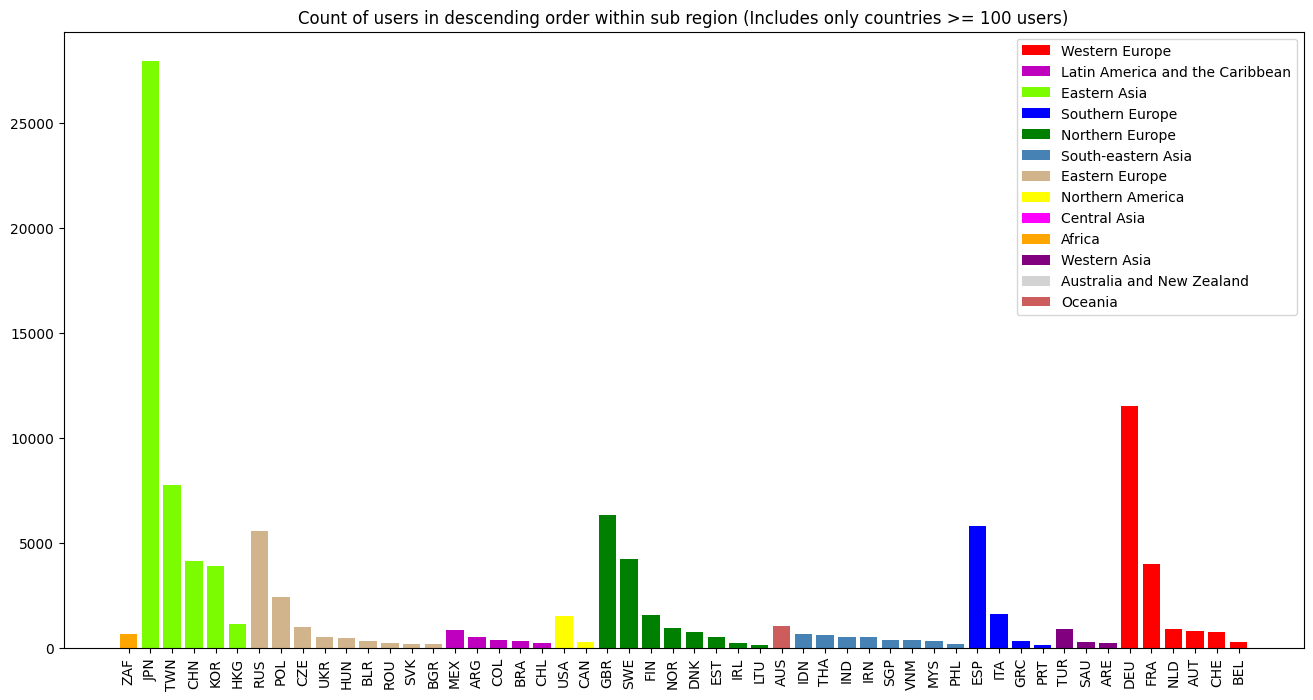

In [5]:
country_by_users= demog_master[['user_id','country',
                                 'sub-region-2']].groupby(['sub-region-2','country']).nunique().reset_index()
country_by_users.sort_values(by=['sub-region-2','user_id'],ascending = [True,False],inplace=True)
country_by_users = country_by_users[country_by_users['user_id']>100]

#Sub-region color dictionary:
sub_region_color_dict = {'Western Europe': 'red',
'Latin America and the Caribbean': 'm',
'Eastern Asia': 'lawngreen',
'Southern Europe' : 'blue',
'Northern Europe': 'green',
'South-eastern Asia' : 'steelblue',
'Eastern Europe' :  'tan',
'Northern America': 'yellow',
'Central Asia' : 'magenta',
# 'Sub-Saharan Africa' : 'orange',
'Africa' : 'orange',
'Western Asia': 'purple',
'Australia and New Zealand' : 'lightgrey',
# 'Southern Asia' : 'peachpuff',
# 'Northern Africa' : 'cyan',
# 'Melanesia' : 'cadetblue',
# 'Polynesia' : 'khaki',
'Oceania' : 'indianred'
                        }
c = country_by_users['sub-region-2'].apply(lambda x:sub_region_color_dict[x] )
# country_by_users
fig,axs = plt.subplots(figsize=(16,8))

axs.bar(country_by_users['country'],country_by_users['user_id'],color=c)
for i, j in sub_region_color_dict.items():
    axs.bar(country_by_users['country'],country_by_users['user_id'],width=0,color=j,label=i)
axs.legend(loc='upper right')
plt.xticks(rotation=90)
plt.title("Count of users in descending order within sub region (Includes only countries >= 100 users)")
plt.show()


In [6]:
pp = country_by_users[['sub-region-2','country']].drop_duplicates()
pp

,sub-region-2,country
32,Africa,ZAF
41,Eastern Asia,JPN
46,Eastern Asia,TWN
39,Eastern Asia,CHN
42,Eastern Asia,KOR
40,Eastern Asia,HKG
54,Eastern Europe,RUS
52,Eastern Europe,POL
49,Eastern Europe,CZE
56,Eastern Europe,UKR


In [7]:
country_by_users.to_csv("/file/out/antar/country_by_users.csv")

In [8]:
sleep_sample.columns

Index(['user_id', 'day_of_week', 'weekend', 'start_time_num_round',
       'end_time_num_round', 'sleep_duration', 'sleep_duration_round',
       'sleep_start', 'sleep_start_shift', 'start_time_num_round_25',
       'end_time_num_round_25', 'nap', 'shift_sleep', 'alpha-2', 'alpha-3',
       'sub-region-2', 'latitude', 'longitude'],
      dtype='object')

In [9]:
country_by_users.to_csv("/file/out/antar/country_by_users.csv")

In [10]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_skew'},inplace=True)

_avg = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').mean()
_avg = _avg.reset_index()
_avg.rename(columns={'sleep_duration_round':'sleep_duration_avg'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_skew',ascending=False, inplace=True)

_skew = _skew.merge(_avg, how='left',left_on = 'user_id',right_on='user_id')
_skew

,user_id,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg
0,cdd97da3bba1bc2f786bdae0630c548da32d7d276f987f...,6.540117,2.350,2.5,2.480317
1,751b6ff2ebb8d4b465774e461acc829d495652d9e403ff...,6.260967,2.375,2.5,2.548390
2,95be4aeeb0cea3948bb94641092be92c159c459bc3d634...,5.739585,3.000,3.0,3.018873
3,10efc6828f07e83102d01b86e507bcc4b36d81c782afb5...,5.474701,2.370,2.5,2.657755
4,737f2d41689a4e71291ef2b4d6845b1862d4b1e49a10d7...,5.357708,2.425,2.5,2.436351
...,...,...,...,...,...
112923,3ba78ec51661119c35b24a8a8acdd05b9760b5df11a656...,-3.511816,7.500,7.5,7.469474
112924,8078c2e5d72169c97c08b607d5d59c571f4d801f46fdf4...,-3.519943,8.480,8.5,8.375570
112925,b213f829e63214a7d4b3811e9662d1ca01b0ae7de42de6...,-3.547488,6.875,7.0,6.741852
112926,d00ba82fef5319c328c8a205dc025f3efaedb105427a6c...,-3.560369,10.460,10.5,10.326959


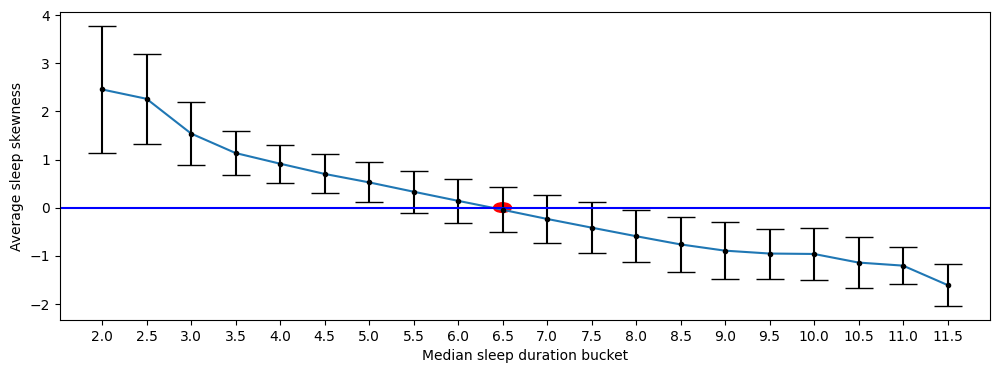

In [11]:
fig2a_1 = _skew[['sleep_dur_median_bucket','sleep_duration_skew']].groupby('sleep_dur_median_bucket').mean()
fig2a_2 = _skew[['sleep_dur_median_bucket','sleep_duration_skew']].groupby('sleep_dur_median_bucket').std()
fig2a_1 = fig2a_1.merge(fig2a_2,left_index=True,right_index=True)
fig2a_1.columns = ['skew_mean','skew_stddev']
freq = pd.DataFrame(_skew['sleep_dur_median_bucket'].value_counts())
freq.columns = ['counts']
fig2a_1 = fig2a_1.merge(freq,left_index=True,right_index=True)
fig2a_1 = fig2a_1.iloc[:-4]
fig,ax = plt.subplots(figsize=(12,4))
import matplotlib.patches as mpatches
plt.plot(fig2a_1.index,fig2a_1['skew_mean'])
plt.errorbar(fig2a_1.index,
             fig2a_1['skew_mean'],
             yerr = fig2a_1['skew_stddev'],
             fmt = '.k',
             capsize=10)
plt.axhline(y=0,color='b',linestyle='-')
circ = plt.Circle((6.5,0),radius = .1,color='red')
ax.add_artist(circ)
# plt.title("Average skewness (with errorbars) for every median sleep duration bucket")
plt.xticks(fig2a_1.index)
plt.xlabel("Median sleep duration bucket")
plt.ylabel("Average sleep skewness")
plt.savefig("/file/out/antar/AvgSkewVsMedianSleep.png",dpi=400)
plt.show()

In [12]:
fig2a_1.T

,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5
skew_mean,2.456428,2.262123,1.540239,1.134524,0.913089,0.700546,0.524636,0.330669,0.140886,-0.044728,-0.235633,-0.416212,-0.594315,-0.765435,-0.895308,-0.955125,-0.964124,-1.142845,-1.206559,-1.609543
skew_stddev,1.325064,0.936307,0.649733,0.462512,0.394135,0.403944,0.414928,0.433309,0.458492,0.470625,0.491597,0.522560,0.546985,0.568845,0.587719,0.519849,0.536712,0.527925,0.389091,0.430685
counts,5.000000,296.000000,466.000000,557.000000,1042.000000,2073.000000,4430.000000,8419.000000,14870.000000,19600.000000,23233.000000,19149.000000,11946.000000,4736.000000,1539.000000,351.000000,108.000000,59.000000,29.000000,14.000000


In [13]:
_skew = _skew.merge(demog_master,how='left',left_on='user_id',right_on= 'user_id')
_skew.head()

,user_id,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg,gender,age_group,country,sub-region-2,latitude,longitude,new_age
0,cdd97da3bba1bc2f786bdae0630c548da32d7d276f987f...,6.540117,2.350,2.5,2.480317,FEMALE,NaN,JPN,Eastern Asia,36.204824,138.252924,5. Missing
1,751b6ff2ebb8d4b465774e461acc829d495652d9e403ff...,6.260967,2.375,2.5,2.548390,FEMALE,NaN,ESP,Southern Europe,40.463667,-3.749220,5. Missing
2,95be4aeeb0cea3948bb94641092be92c159c459bc3d634...,5.739585,3.000,3.0,3.018873,FEMALE,2.0,RUS,Eastern Europe,61.524010,105.318756,3. 54-70
3,10efc6828f07e83102d01b86e507bcc4b36d81c782afb5...,5.474701,2.370,2.5,2.657755,FEMALE,2.0,DEU,Western Europe,51.165691,10.451526,3. 54-70
4,737f2d41689a4e71291ef2b4d6845b1862d4b1e49a10d7...,5.357708,2.425,2.5,2.436351,MALE,2.0,JPN,Eastern Asia,36.204824,138.252924,3. 54-70


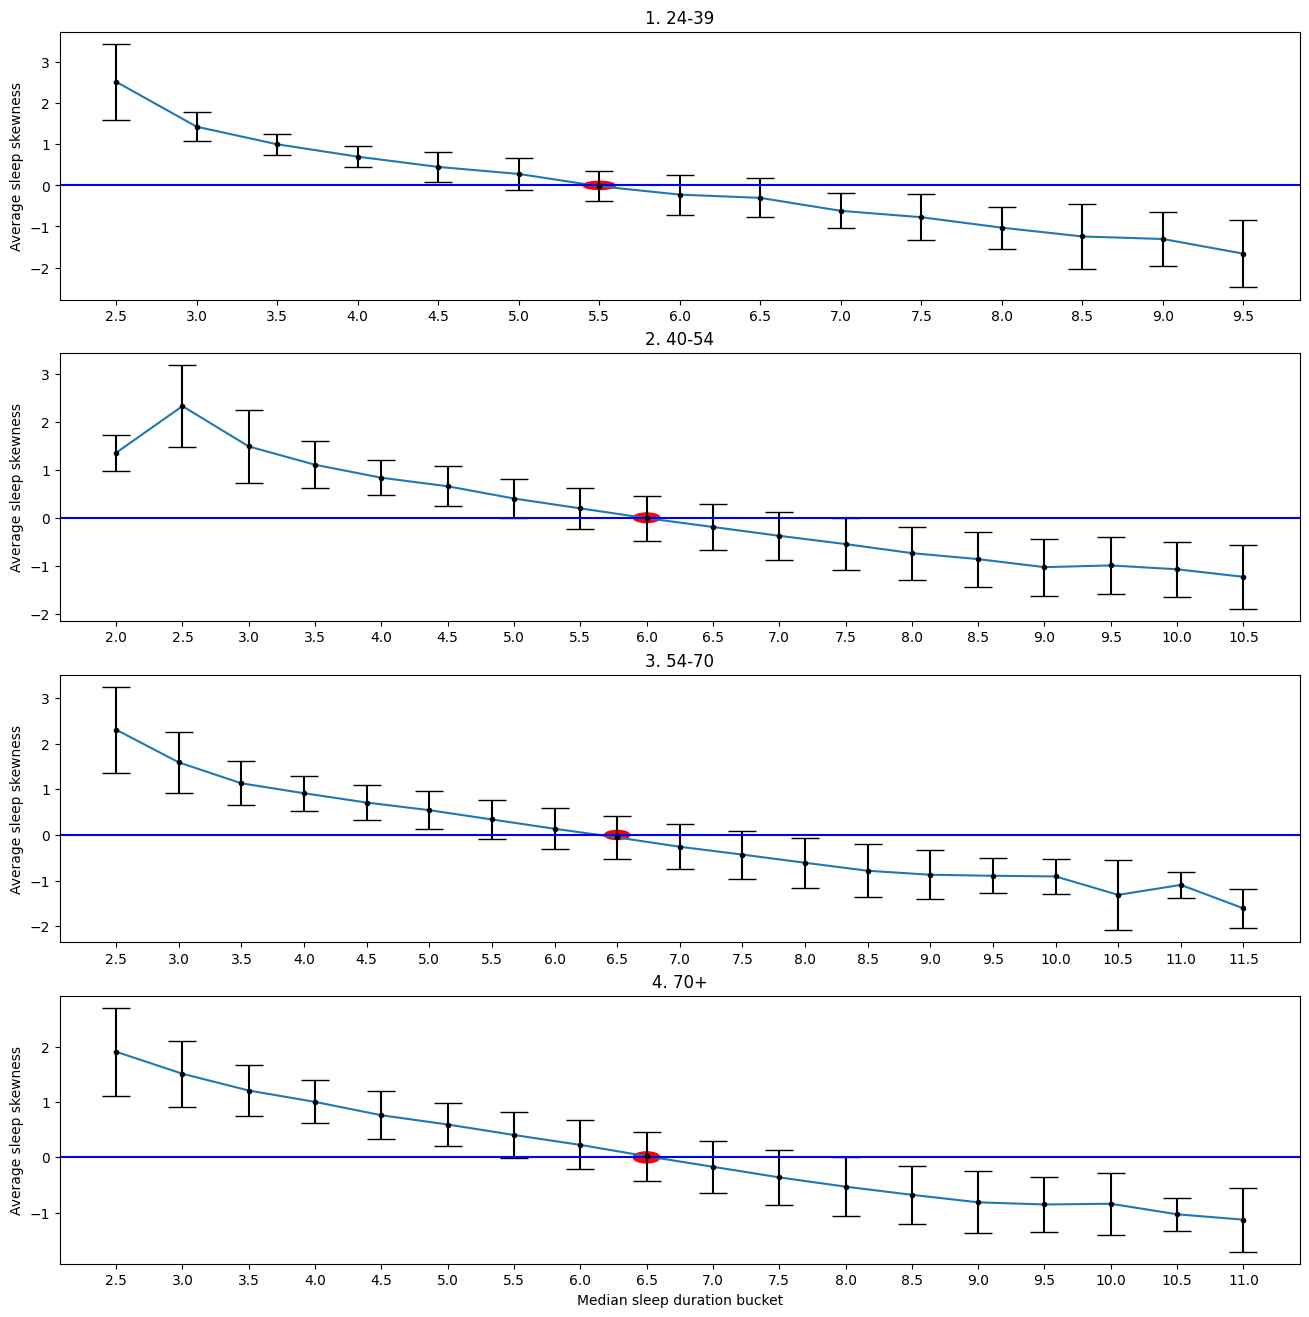

In [14]:
fig,axs = plt.subplots(4,1,figsize=(16,16))
axs = axs.flatten()
for i in range(4):
    fig2a_1 = _skew[_skew['new_age'] == age_choices[i]][['sleep_dur_median_bucket','sleep_duration_skew']].groupby('sleep_dur_median_bucket').mean()
    fig2a_2 = _skew[_skew['new_age'] == age_choices[i]][['sleep_dur_median_bucket','sleep_duration_skew']].groupby('sleep_dur_median_bucket').std()
    fig2a_1 = fig2a_1.merge(fig2a_2,left_index=True,right_index=True)
    fig2a_1.columns = ['skew_mean','skew_stddev']
    fig2a_1 = fig2a_1.iloc[:-2]
    axs[i].plot(fig2a_1.index,fig2a_1['skew_mean'])
    axs[i].errorbar(fig2a_1.index,
                 fig2a_1['skew_mean'],
                 yerr = fig2a_1['skew_stddev'],
                 fmt = '.k',
                 capsize=10)
    axs[i].axhline(y=0,color='b',linestyle='-')
    axs[i].set_title(age_choices[i])
    axs[i].set_xticks(fig2a_1.index)
    if i == 3:
        axs[i].set_xlabel("Median sleep duration bucket")
    axs[i].set_ylabel("Average sleep skewness")
circ = plt.Circle((5.5,0),radius = .1,color='red')
axs[0].add_artist(circ)   
circ = plt.Circle((6.0,0),radius = .1,color='red')
axs[1].add_artist(circ)   
circ = plt.Circle((6.5,0),radius = .1,color='red')
axs[2].add_artist(circ)  
circ = plt.Circle((6.5,0),radius = .1,color='red')
axs[3].add_artist(circ)  
plt.savefig("/file/out/antar/AgeVsSleepSkew.png", dpi=400)
plt.show()

## Countries by sleep skew

In [15]:
_skew[_skew['country']=='FIN'][['sleep_duration_skew']].std()
# sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()

sleep_duration_skew    0.586735
dtype: float64

/tmp/ipykernel_770655/483539890.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[1].errorbar(skew_by_country['country'],


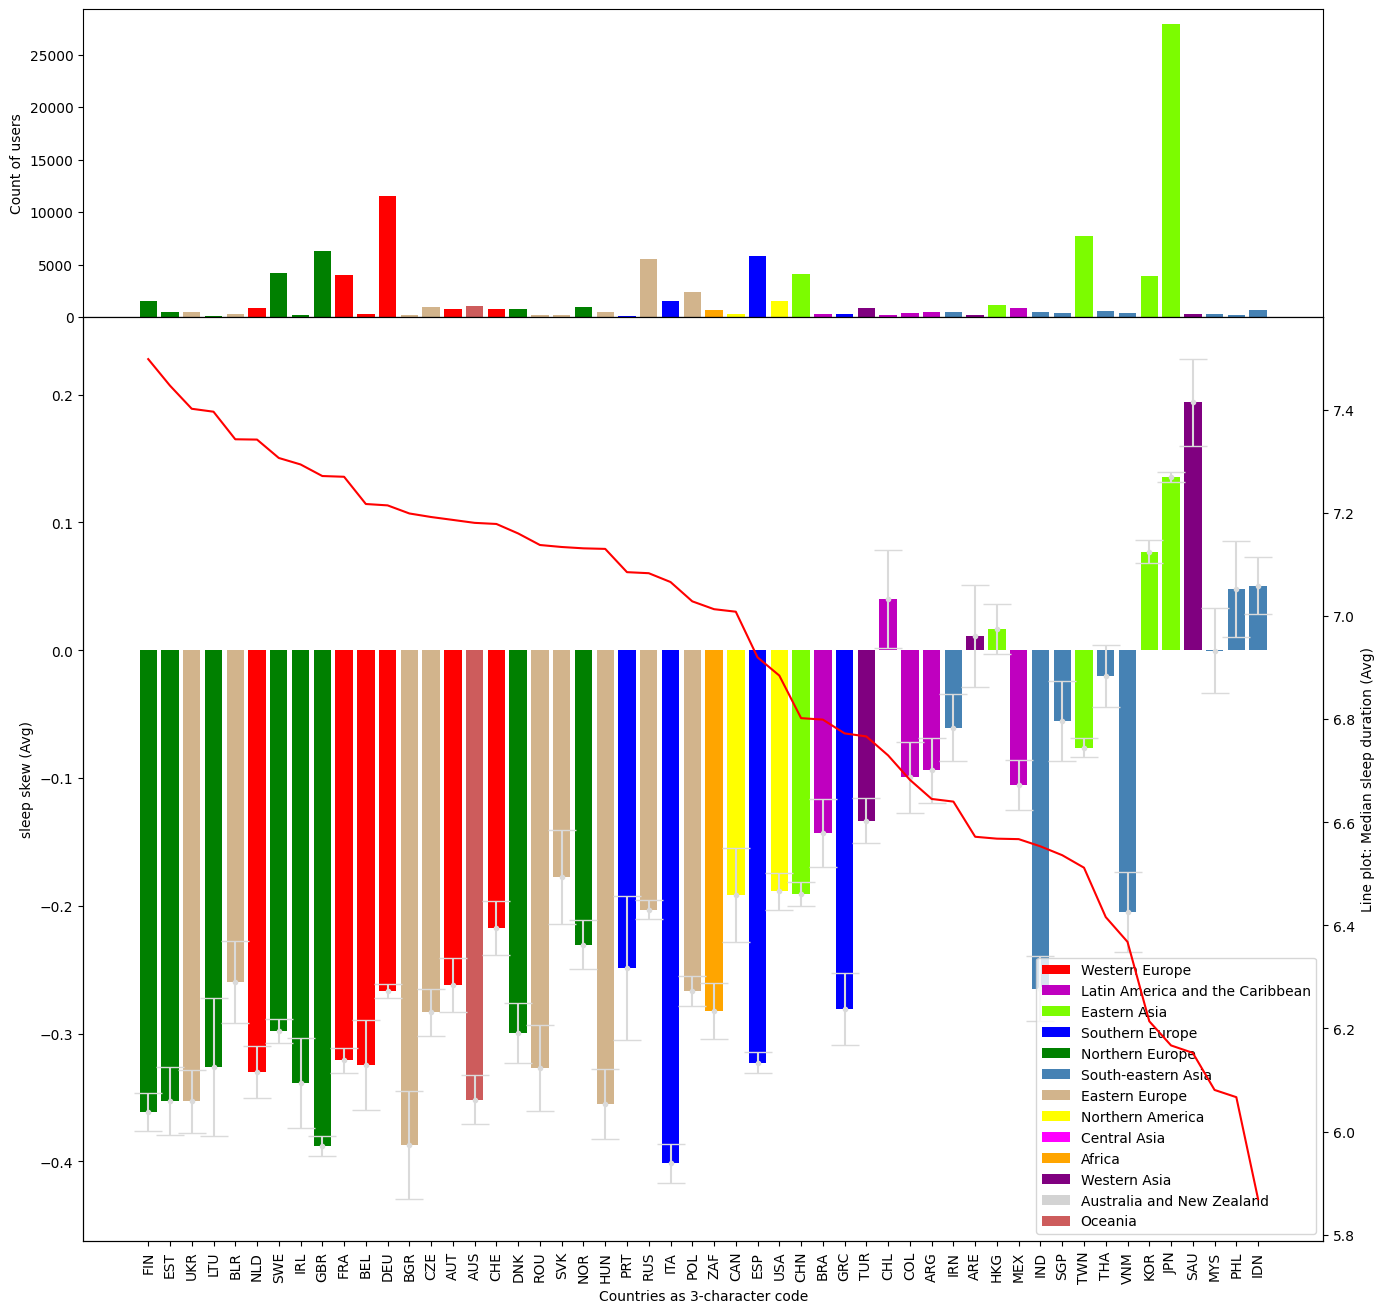

In [16]:
skew_by_country = _skew[['sub-region-2','country','sleep_duration_skew']].groupby(['sub-region-2',
                                                                                   'country']).agg(["mean",
                                                                                                    "count","std"]).reset_index()
skew_by_country.columns=['sub-region-2','country','sleep_duration_skew','count_of_users','skew_stddev']
skew_by_country['skew_std_error'] = skew_by_country['skew_stddev']/(np.sqrt(skew_by_country['count_of_users']))
skew_by_country = skew_by_country[skew_by_country['count_of_users']>=100]

dur_by_country = _skew[['country','sleep_duration_median']].groupby('country').agg(["mean","count"]).reset_index()
dur_by_country.columns=['country','sleep_duration_median','count_of_users']
# dur_by_country = dur_by_country[dur_by_country['count_of_users']>=100]

skew_by_country= skew_by_country.merge(dur_by_country[['country','sleep_duration_median']],how='inner',
                                      left_on='country',right_on='country')

skew_by_country.sort_values(by='sleep_duration_median',ascending=False, inplace=True)

c = skew_by_country['sub-region-2'].apply(lambda x:sub_region_color_dict[x] )
# country_by_users

from textwrap import wrap
fig,axs = plt.subplots(2,1, sharex=True,figsize=(16,16), gridspec_kw = {'height_ratios': [1,3]})
plt.subplots_adjust(hspace=0)
axs = axs.flatten()
axs[0].bar(skew_by_country['country'], skew_by_country['count_of_users'],color=c)

ax = axs[1].twinx()
axs[1].bar(skew_by_country['country'],skew_by_country['sleep_duration_skew'],color=c)
ax.plot(skew_by_country['country'],skew_by_country['sleep_duration_median'],color='red')
axs[1].errorbar(skew_by_country['country'],
             skew_by_country['sleep_duration_skew'],
             yerr = skew_by_country['skew_std_error'],color='#dadada',
             fmt = '.k',
             capsize=10)
ax.set_ylabel("Line plot: Median sleep duration (Avg)")

for i, j in sub_region_color_dict.items():
    axs[1].bar(skew_by_country['country'],skew_by_country['sleep_duration_skew'],width=0,color=j,label=i)
axs[1].legend(loc='lower right')

# plt.title("\n".join(wrap("Line plot: Countries in descending order of Avg(median(sleep duration)) Bar plot: avg sleep skew. \
# \
# Strong contrast between Northern Europe vs Asia: High median sleep and negative skew vs low median sleep and positive skew",100)))
ax.set_xlabel("Countries")
axs[0].set_ylabel("Count of users")
axs[1].tick_params("x",labelrotation=90)
axs[1].set_ylabel("sleep skew (Avg)")
axs[1].set_xlabel("Countries as 3-character code")
plt.savefig("/file/out/antar/CountryVsSleepSkew.png",dpi=400)
plt.show()



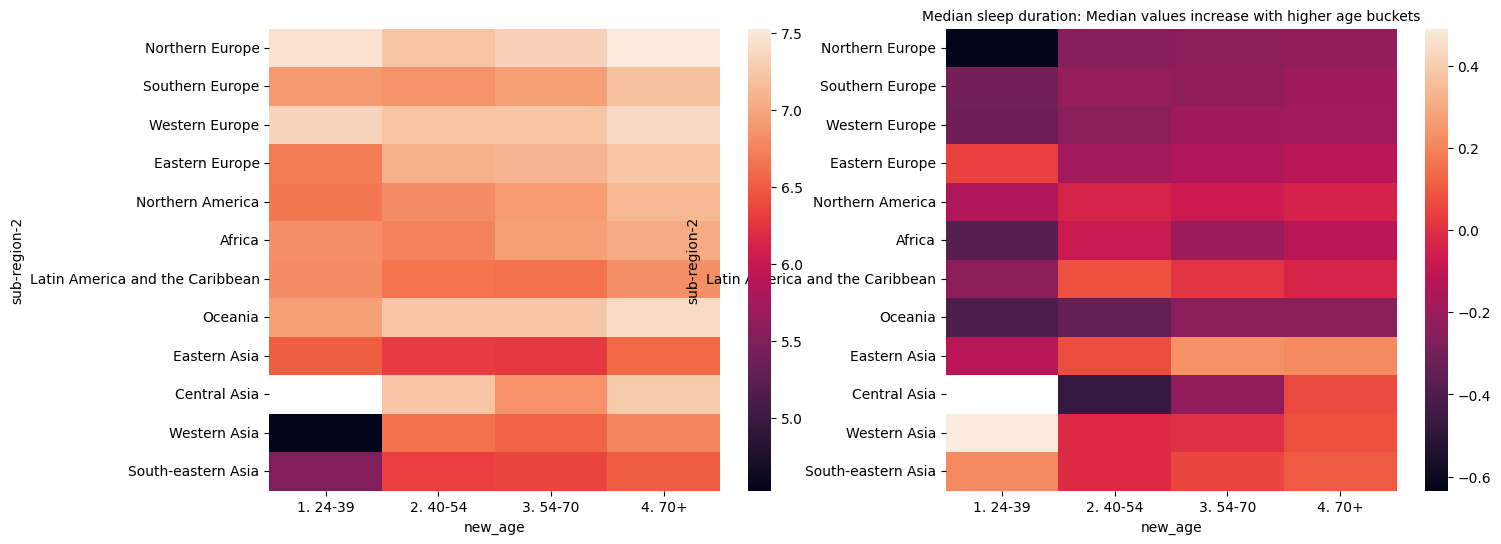

In [72]:
age_region_heatmap = sleep_sample_rollup[['new_age','sub-region-2',
                                          'sleep_duration_hour']].groupby(['new_age','sub-region-2']).median().reset_index()

age_region_heatmap_pv = age_region_heatmap.pivot(index='sub-region-2',columns='new_age',values='sleep_duration_hour')

custom_region_order = {'Northern Europe':0,'Southern Europe':1,'Western Europe':2,'Eastern Europe':3,
                       'Northern America': 4, 'Africa':5,'Latin America and the Caribbean':6, 'Oceania':7,
                       'Eastern Asia':8,'Central Asia':9, 'Western Asia':10,
                       'South-eastern Asia':11}
age_region_heatmap_pv = age_region_heatmap_pv.reset_index()
age_region_heatmap_pv.sort_values(by='sub-region-2',key=lambda x:x.map(custom_region_order),inplace=True)
age_region_heatmap_pv.drop(columns={'5. Missing'},inplace=True)
age_region_heatmap_pv = age_region_heatmap_pv.set_index('sub-region-2')

import seaborn as sns
fig,axs = plt.subplots(1,2,figsize=(16,6))
axs=axs.flatten()
sns.heatmap(data=age_region_heatmap_pv,ax=axs[0])

age_region_heatmap = sleep_sample_rollup[['new_age','sub-region-2',
                                          'sleep_duration_hour']].groupby(['new_age','sub-region-2']).skew().reset_index()

age_region_heatmap_pv = age_region_heatmap.pivot(index='sub-region-2',columns='new_age',values='sleep_duration_hour')

custom_region_order = {'Northern Europe':0,'Southern Europe':1,'Western Europe':2,'Eastern Europe':3,
                       'Northern America': 4, 'Africa':5,'Latin America and the Caribbean':6, 'Oceania':7,
                       'Eastern Asia':8,'Central Asia':9, 'Western Asia':10,
                       'South-eastern Asia':11}
age_region_heatmap_pv = age_region_heatmap_pv.reset_index()
age_region_heatmap_pv.sort_values(by='sub-region-2',key=lambda x:x.map(custom_region_order),inplace=True)
age_region_heatmap_pv.drop(columns={'5. Missing'},inplace=True)
age_region_heatmap_pv = age_region_heatmap_pv.set_index('sub-region-2')
sns.heatmap(data=age_region_heatmap_pv,ax=axs[1])
# plt.title("Median sleep duration: Median values increase with higher age buckets",fontsize=10)
plt.show()

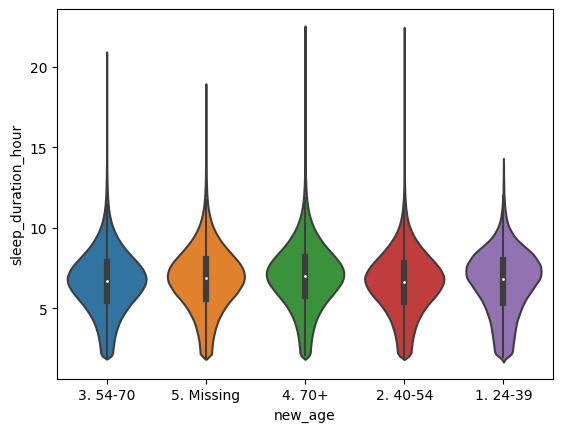

In [75]:
north_europe_violin = sleep_sample_rollup[(sleep_sample_rollup['sub-region-2']=='Northern Europe') &
                   sleep_sample_rollup['new_age']!='5. Missing'][['new_age','sleep_duration_hour']]
sns.violinplot(north_europe_violin,x="new_age",y = "sleep_duration_hour")
plt.show()

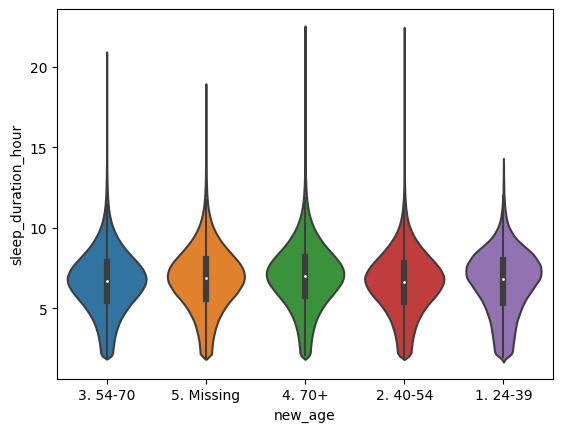

In [76]:
southeastern_asia_violin = sleep_sample_rollup[(sleep_sample_rollup['sub-region-2']=='South-eastern Europe') &
                   sleep_sample_rollup['new_age']!='5. Missing'][['new_age','sleep_duration_hour']]
sns.violinplot(southeastern_asia_violin,x="new_age",y = "sleep_duration_hour")
plt.show()

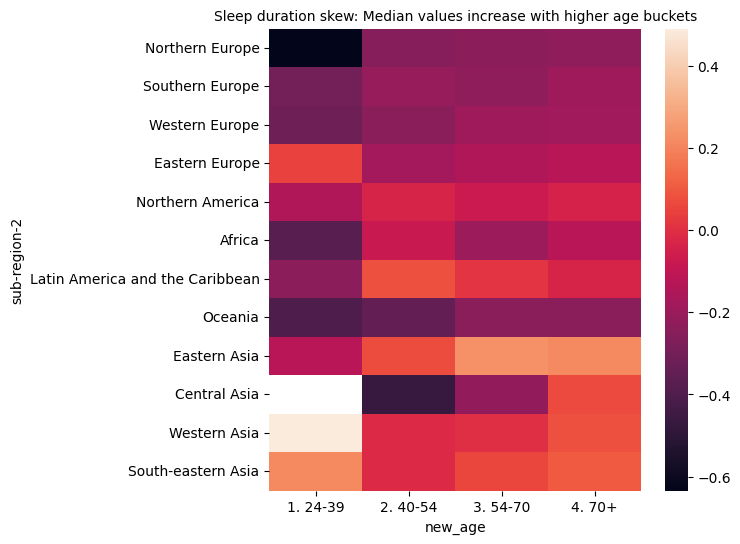

In [70]:
age_region_heatmap = sleep_sample_rollup[['new_age','sub-region-2',
                                          'sleep_duration_hour']].groupby(['new_age','sub-region-2']).skew().reset_index()

age_region_heatmap_pv = age_region_heatmap.pivot(index='sub-region-2',columns='new_age',values='sleep_duration_hour')

custom_region_order = {'Northern Europe':0,'Southern Europe':1,'Western Europe':2,'Eastern Europe':3,
                       'Northern America': 4, 'Africa':5,'Latin America and the Caribbean':6, 'Oceania':7,
                       'Eastern Asia':8,'Central Asia':9, 'Western Asia':10,
                       'South-eastern Asia':11}
age_region_heatmap_pv = age_region_heatmap_pv.reset_index()
age_region_heatmap_pv.sort_values(by='sub-region-2',key=lambda x:x.map(custom_region_order),inplace=True)
age_region_heatmap_pv.drop(columns={'5. Missing'},inplace=True)
age_region_heatmap_pv = age_region_heatmap_pv.set_index('sub-region-2')
age_region_heatmap_pv
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(data=age_region_heatmap_pv)
plt.title("Sleep duration skew: Median values increase with higher age buckets",fontsize=10)
plt.show()

In [21]:
from ipyleaflet import Map
m = Map(center=(0,0),zoom=2)
m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [25]:
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import HeatMap
map_World = folium.Map(location=[45.372,0],
                       tiles='Stamen Terrain',
                       zoom_start = 2, control_scale=True)
display(map_World)                               

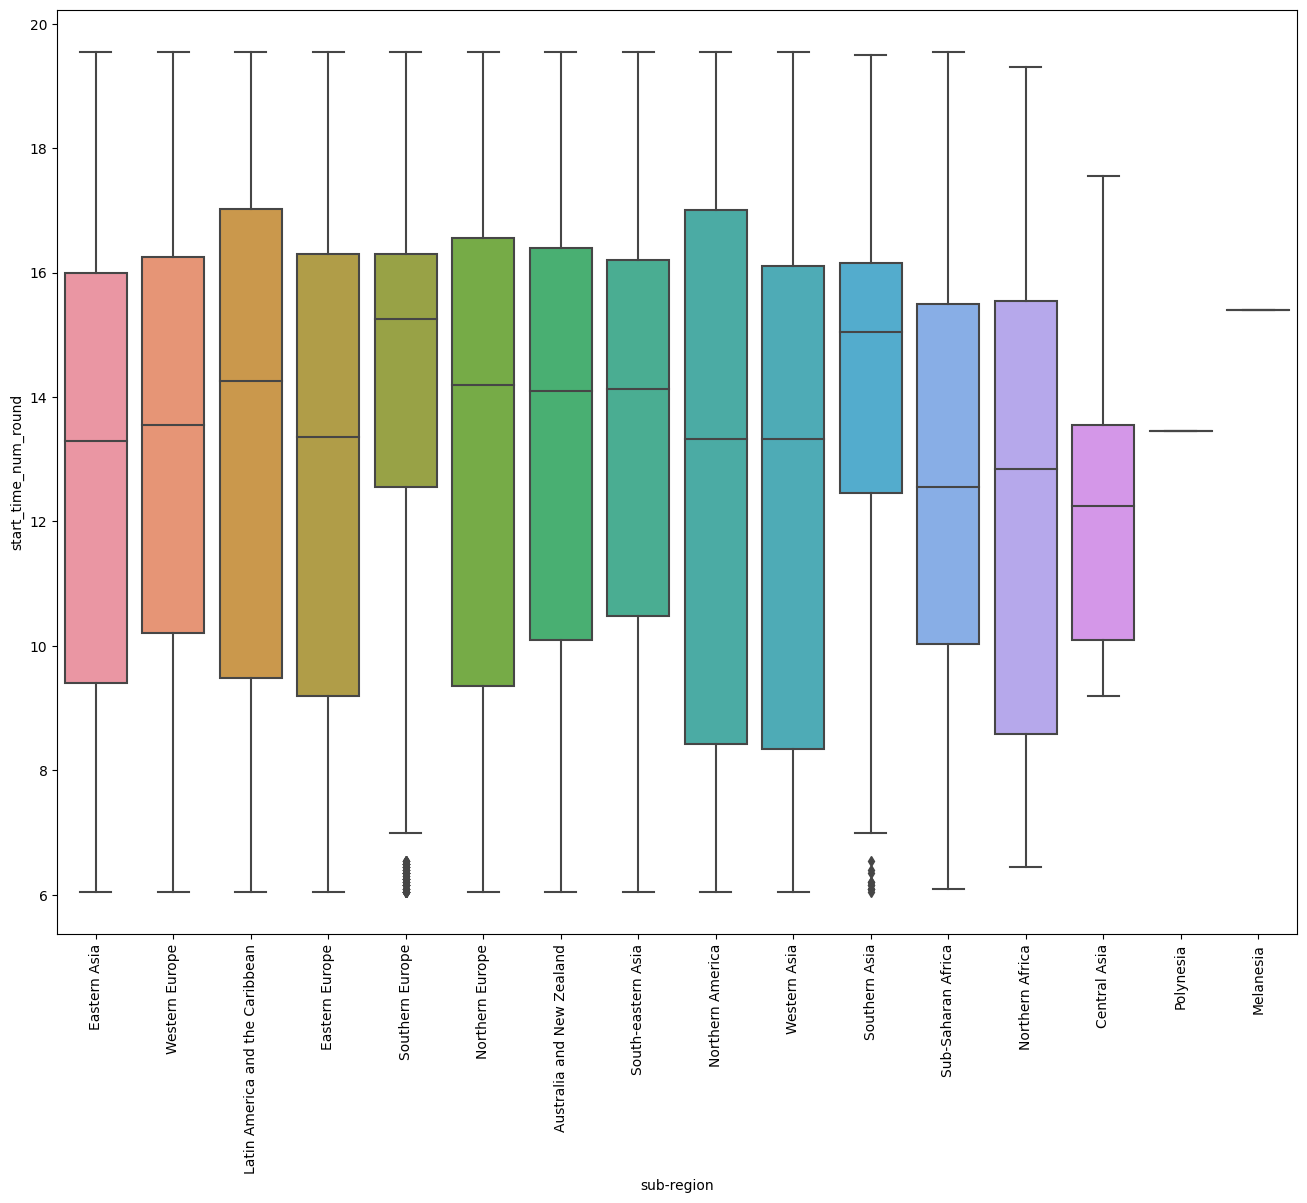

In [57]:
import seaborn as sns
plt.figure(figsize=(16,12))
sns.boxplot(data=naps,x=naps["sub-region"] , y=naps["start_time_num_round"])
plt.xticks(rotation=90)
plt.show()